### Import necessary libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scipy as sp
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from scipy import stats
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

### Read in csv files

In [2]:
d_20 = pd.read_csv('offense-2020.csv')
o_20 = pd.read_csv('defense-2020.csv')

d_19 = pd.read_csv('offense-2019.csv')
o_19 = pd.read_csv('defense-2019.csv')

d_18 = pd.read_csv('offense-2018.csv')
o_18 = pd.read_csv('defense-2018.csv')

d_17 = pd.read_csv('offense-2017.csv')
o_17 = pd.read_csv('defense-2017.csv')

d_16 = pd.read_csv('offense-2016.csv')
o_16 = pd.read_csv('defense-2016.csv')

d_15 = pd.read_csv('offense-2015.csv')
o_15 = pd.read_csv('defense-2015.csv')

d_14 = pd.read_csv('offense-2014.csv')
o_14 = pd.read_csv('defense-2014.csv')

d_13 = pd.read_csv('offense-2013.csv')
o_13 = pd.read_csv('defense-2013.csv')

d_12 = pd.read_csv('offense-2012.csv')
o_12 = pd.read_csv('defense-2012.csv')

d_11 = pd.read_csv('offense-2011.csv')
o_11 = pd.read_csv('defense-2011.csv')

d_10 = pd.read_csv('offense-2010.csv')
o_10 = pd.read_csv('defense-2010.csv')

d_09 = pd.read_csv('offense-2009.csv')
o_09 = pd.read_csv('defense-2009.csv')

d_08 = pd.read_csv('offense-2008.csv')
o_08 = pd.read_csv('defense-2008.csv')

d_07 = pd.read_csv('offense-2007.csv')
o_07 = pd.read_csv('defense-2007.csv')

d_06 = pd.read_csv('offense-2006.csv')
o_06 = pd.read_csv('defense-2006.csv')

d_05 = pd.read_csv('offense-2005.csv')
o_05 = pd.read_csv('defense-2005.csv')

d_04 = pd.read_csv('offense-2004.csv')
o_04 = pd.read_csv('defense-2004.csv')

d_03 = pd.read_csv('offense-2003.csv')
o_03 = pd.read_csv('defense-2003.csv')

d_02 = pd.read_csv('offense-2002.csv')
o_02 = pd.read_csv('defense-2002.csv')

d_01 = pd.read_csv('offense-2001.csv')
o_01 = pd.read_csv('defense-2001.csv')

d_00 = pd.read_csv('offense-2000.csv')
o_00 = pd.read_csv('defense-2000.csv')

In [3]:
df_list = [d_19,o_19,d_18,o_18,d_17,o_17,d_16,o_16,d_15,o_15,d_14,o_14,d_13,o_13,d_12,o_12,d_11,o_11,d_10,o_10,d_09,o_09,d_08,o_08,d_07,o_07,d_06,o_06,d_05,o_05,d_04,o_04,d_03,o_03,d_02,o_02,d_01,o_01,d_00,o_00]

In [4]:
df = pd.concat(df_list)

In [5]:
df.shape

(6319, 17)

### Clean Data

In [6]:
#clean names column
name_list = []
for i in df.Player:
    player_list = i.split("\\")
    name_list.append(player_list[0])
df.Player = name_list

In [7]:
#handle undrafted players by replacing nan with 8
round_dict = {np.nan:'No Team / 8th / 700th pick / 2100'}
df['Drafted (tm/rnd/yr)'].replace(round_dict, inplace = True)

In [8]:
# impute mean age (roughly)
age_dict = {np.nan:22}
df['Age'].replace(age_dict, inplace = True)

In [9]:
#clean draft position of players in new_df
clean_round_drafted = []
for i in df['Drafted (tm/rnd/yr)']:
    draft_list = i.split("/")
    round_drafted = draft_list[1][1]
    clean_round_drafted.append(round_drafted)
df['Round'] = clean_round_drafted
df.drop(columns = ['Drafted (tm/rnd/yr)'], inplace = True)

In [10]:
df.drop(columns = ['Rk', 'AV', 'College'], inplace = True)

In [11]:
# map infrequent and new positions to pre-existing ones with similar responsibilities and qualities
pos_dict = {'S':'FS', 'OL':'OG', 'DL':'DT', 'LB':'OLB', 'EDGE':'DE'}
df.Pos.replace(pos_dict, inplace = True)

### Deal with missing data

In [12]:
# create list of values to impute for non-participants of events (by position)
mean_by_pos_40 = df.groupby('Pos')['40YD'].mean()
std_by_pos_40 = df.groupby('Pos')['40YD'].std()
nan_penalty_40 = mean_by_pos_40 + .5*std_by_pos_40

mean_by_pos_vert = df.groupby('Pos')['Vertical'].mean()
std_by_pos_vert = df.groupby('Pos')['Vertical'].std()
nan_penalty_vert = mean_by_pos_vert - .5*std_by_pos_vert

mean_by_pos_bench = df.groupby('Pos')['BenchReps'].mean()
std_by_pos_bench = df.groupby('Pos')['BenchReps'].std()
nan_penalty_bench = mean_by_pos_bench - .5*std_by_pos_bench

mean_by_pos_broad = df.groupby('Pos')['Broad Jump'].mean()
std_by_pos_broad = df.groupby('Pos')['Broad Jump'].std()
nan_penalty_broad = mean_by_pos_broad - .5*std_by_pos_broad


mean_by_pos_3cone = df.groupby('Pos')['3Cone'].mean()
std_by_pos_3cone = df.groupby('Pos')['3Cone'].std()
nan_penalty_3cone = mean_by_pos_3cone + .5*std_by_pos_3cone

mean_by_pos_shuttle = df.groupby('Pos')['Shuttle'].mean()
std_by_pos_shuttle = df.groupby('Pos')['Shuttle'].std()
nan_penalty_shuttle = mean_by_pos_shuttle + .5*std_by_pos_shuttle

In [13]:
print("nan_penalty_40")
print(nan_penalty_40)
print("")
print("nan_penalty_vert")
print(nan_penalty_vert)
print("")
print("nan_penalty_bench")
print(nan_penalty_bench)
print("")
print("nan_penalty_broad")
print(nan_penalty_broad)
print("")
print("nan_penalty_3cone")
print(nan_penalty_3cone)
print("")
print("nan_penalty_shuttle")
print(nan_penalty_shuttle)

nan_penalty_40
Pos
C      5.319924
CB     4.541584
DE     4.893102
DT     5.170493
FB     4.832669
FS     4.609266
ILB    4.814414
OG     5.394333
OLB    4.734316
OT     5.339185
QB     4.914067
RB     4.611794
SS     4.619766
TE     4.841208
WR     4.562142
Name: 40YD, dtype: float64

nan_penalty_vert
Pos
C      26.509700
CB     34.577116
DE     31.450307
DT     27.864409
FB     31.210632
FS     34.166669
ILB    31.735044
OG     26.062851
OLB    32.804533
OT     26.537368
QB     29.496755
RB     32.895829
SS     33.883471
TE     31.340777
WR     33.725323
Name: Vertical, dtype: float64

nan_penalty_bench
Pos
C      23.646150
CB     12.432329
DE     21.387198
DT     24.903738
FB     20.370783
FS     14.360253
ILB    20.165818
OG     22.926322
OLB    20.045840
OT     21.961435
QB     17.145077
RB     17.113607
SS     15.365649
TE     18.028782
WR     12.486491
Name: BenchReps, dtype: float64

nan_penalty_broad
Pos
C       98.421912
CB     119.022484
DE     111.816697
DT     102.186387
F

In [14]:
df.set_index('Pos', inplace = True)

In [15]:
# make positional dataframes
C = df.loc['C', :]
CB = df.loc['CB', :]
DE = df.loc['DE', :]
DT = df.loc['DT', :]
FB = df.loc['FB', :]
FS = df.loc['FS', :]
ILB = df.loc['ILB', :]
OG = df.loc['OG', :]
OLB = df.loc['OLB', :]
OT = df.loc['OT', :]
QB = df.loc['QB', :]
RB = df.loc['RB', :]
SS = df.loc['SS', :]
TE = df.loc['TE', :]
WR = df.loc['WR', :]

In [16]:
C['40YD'].fillna(nan_penalty_40['C'], inplace = True)
CB['40YD'].fillna(nan_penalty_40['CB'], inplace = True)
DE['40YD'].fillna(nan_penalty_40['DE'], inplace = True)
DT['40YD'].fillna(nan_penalty_40['DT'], inplace = True)
FB['40YD'].fillna(nan_penalty_40['FB'], inplace = True)
FS['40YD'].fillna(nan_penalty_40['FS'], inplace = True)
ILB['40YD'].fillna(nan_penalty_40['ILB'], inplace = True)
OG['40YD'].fillna(nan_penalty_40['OG'], inplace = True)
OLB['40YD'].fillna(nan_penalty_40['OLB'], inplace = True)
OT['40YD'].fillna(nan_penalty_40['OT'], inplace = True)
QB['40YD'].fillna(nan_penalty_40['QB'], inplace = True)
RB['40YD'].fillna(nan_penalty_40['RB'], inplace = True)
SS['40YD'].fillna(nan_penalty_40['SS'], inplace = True)
TE['40YD'].fillna(nan_penalty_40['TE'], inplace = True)
WR['40YD'].fillna(nan_penalty_40['WR'], inplace = True)

/Users/lucas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [17]:
C['Vertical'].fillna(nan_penalty_vert['C'], inplace = True)
CB['Vertical'].fillna(nan_penalty_vert['CB'], inplace = True)
DE['Vertical'].fillna(nan_penalty_vert['DE'], inplace = True)
DT['Vertical'].fillna(nan_penalty_vert['DT'], inplace = True)
FB['Vertical'].fillna(nan_penalty_vert['FB'], inplace = True)
FS['Vertical'].fillna(nan_penalty_vert['FS'], inplace = True)
ILB['Vertical'].fillna(nan_penalty_vert['ILB'], inplace = True)
OG['Vertical'].fillna(nan_penalty_vert['OG'], inplace = True)
OLB['Vertical'].fillna(nan_penalty_vert['OLB'], inplace = True)
OT['Vertical'].fillna(nan_penalty_vert['OT'], inplace = True)
QB['Vertical'].fillna(nan_penalty_vert['QB'], inplace = True)
RB['Vertical'].fillna(nan_penalty_vert['RB'], inplace = True)
SS['Vertical'].fillna(nan_penalty_vert['SS'], inplace = True)
TE['Vertical'].fillna(nan_penalty_vert['TE'], inplace = True)
WR['Vertical'].fillna(nan_penalty_vert['WR'], inplace = True)

In [18]:
C['BenchReps'].fillna(nan_penalty_bench['C'], inplace = True)
CB['BenchReps'].fillna(nan_penalty_bench['CB'], inplace = True)
DE['BenchReps'].fillna(nan_penalty_bench['DE'], inplace = True)
DT['BenchReps'].fillna(nan_penalty_bench['DT'], inplace = True)
FB['BenchReps'].fillna(nan_penalty_bench['FB'], inplace = True)
FS['BenchReps'].fillna(nan_penalty_bench['FS'], inplace = True)
ILB['BenchReps'].fillna(nan_penalty_bench['ILB'], inplace = True)
OG['BenchReps'].fillna(nan_penalty_bench['OG'], inplace = True)
OLB['BenchReps'].fillna(nan_penalty_bench['OLB'], inplace = True)
OT['BenchReps'].fillna(nan_penalty_bench['OT'], inplace = True)
QB['BenchReps'].fillna(nan_penalty_bench['QB'], inplace = True)
RB['BenchReps'].fillna(nan_penalty_bench['RB'], inplace = True)
SS['BenchReps'].fillna(nan_penalty_bench['SS'], inplace = True)
TE['BenchReps'].fillna(nan_penalty_bench['TE'], inplace = True)
WR['BenchReps'].fillna(nan_penalty_bench['WR'], inplace = True)

In [19]:
C['Broad Jump'].fillna(nan_penalty_broad['C'], inplace = True)
CB['Broad Jump'].fillna(nan_penalty_broad['CB'], inplace = True)
DE['Broad Jump'].fillna(nan_penalty_broad['DE'], inplace = True)
DT['Broad Jump'].fillna(nan_penalty_broad['DT'], inplace = True)
FB['Broad Jump'].fillna(nan_penalty_broad['FB'], inplace = True)
FS['Broad Jump'].fillna(nan_penalty_broad['FS'], inplace = True)
ILB['Broad Jump'].fillna(nan_penalty_broad['ILB'], inplace = True)
OG['Broad Jump'].fillna(nan_penalty_broad['OG'], inplace = True)
OLB['Broad Jump'].fillna(nan_penalty_broad['OLB'], inplace = True)
OT['Broad Jump'].fillna(nan_penalty_broad['OT'], inplace = True)
QB['Broad Jump'].fillna(nan_penalty_broad['QB'], inplace = True)
RB['Broad Jump'].fillna(nan_penalty_broad['RB'], inplace = True)
SS['Broad Jump'].fillna(nan_penalty_broad['SS'], inplace = True)
TE['Broad Jump'].fillna(nan_penalty_broad['TE'], inplace = True)
WR['Broad Jump'].fillna(nan_penalty_broad['WR'], inplace = True)

In [20]:
C['3Cone'].fillna(nan_penalty_3cone['C'], inplace = True)
CB['3Cone'].fillna(nan_penalty_3cone['CB'], inplace = True)
DE['3Cone'].fillna(nan_penalty_3cone['DE'], inplace = True)
DT['3Cone'].fillna(nan_penalty_3cone['DT'], inplace = True)
FB['3Cone'].fillna(nan_penalty_3cone['FB'], inplace = True)
FS['3Cone'].fillna(nan_penalty_3cone['FS'], inplace = True)
ILB['3Cone'].fillna(nan_penalty_3cone['ILB'], inplace = True)
OG['3Cone'].fillna(nan_penalty_3cone['OG'], inplace = True)
OLB['3Cone'].fillna(nan_penalty_3cone['OLB'], inplace = True)
OT['3Cone'].fillna(nan_penalty_3cone['OT'], inplace = True)
QB['3Cone'].fillna(nan_penalty_3cone['QB'], inplace = True)
RB['3Cone'].fillna(nan_penalty_3cone['RB'], inplace = True)
SS['3Cone'].fillna(nan_penalty_3cone['SS'], inplace = True)
TE['3Cone'].fillna(nan_penalty_3cone['TE'], inplace = True)
WR['3Cone'].fillna(nan_penalty_3cone['WR'], inplace = True)

In [21]:
C['Shuttle'].fillna(nan_penalty_shuttle['C'], inplace = True)
CB['Shuttle'].fillna(nan_penalty_shuttle['CB'], inplace = True)
DE['Shuttle'].fillna(nan_penalty_shuttle['DE'], inplace = True)
DT['Shuttle'].fillna(nan_penalty_shuttle['DT'], inplace = True)
FB['Shuttle'].fillna(nan_penalty_shuttle['FB'], inplace = True)
FS['Shuttle'].fillna(nan_penalty_shuttle['FS'], inplace = True)
ILB['Shuttle'].fillna(nan_penalty_shuttle['ILB'], inplace = True)
OG['Shuttle'].fillna(nan_penalty_shuttle['OG'], inplace = True)
OLB['Shuttle'].fillna(nan_penalty_shuttle['OLB'], inplace = True)
OT['Shuttle'].fillna(nan_penalty_shuttle['OT'], inplace = True)
QB['Shuttle'].fillna(nan_penalty_shuttle['QB'], inplace = True)
RB['Shuttle'].fillna(nan_penalty_shuttle['RB'], inplace = True)
SS['Shuttle'].fillna(nan_penalty_shuttle['SS'], inplace = True)
TE['Shuttle'].fillna(nan_penalty_shuttle['TE'], inplace = True)
WR['Shuttle'].fillna(nan_penalty_shuttle['WR'], inplace = True)

In [22]:
pos_dfs = [C,CB,DE,DT,FB,FS,ILB,OG,OLB,OT,QB,RB,SS,TE,WR]
new_df = pd.concat(pos_dfs) 

In [23]:
new_df.shape

(6319, 13)

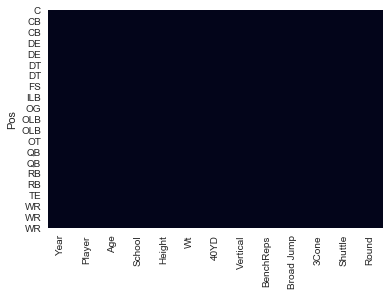

In [24]:
sns.heatmap(new_df.isnull(), cbar = False)

In [25]:
# coerce height from string to int
split_lst = []
for i in range(len(new_df)):
    split_lst.append(new_df.iloc[i,4].split("-"))

ht_lst = []
for i in split_lst:
    ht_lst.append(12*int(i[0]) + int(i[1]))
new_df['Height'] = ht_lst

In [26]:
# create a column for position
new_df['Position'] = [new_df.index[i] for i in range(len(new_df))]

In [27]:
# reindex with normal numerical index column
new_df.reset_index(drop = True, inplace = True)

In [28]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position
0,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C
1,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C
2,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C
3,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C
4,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C


In [29]:
# make round an int rather than a string
new_df['Round'] = [int(i) for i in new_df['Round']]

In [30]:
# created a coumn for drafted/undrafted
new_df['Drafted'] = [1 if i < 8 else 0 for i in new_df['Round']]

In [31]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position,Drafted
0,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C,0
1,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C,0
2,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C,1
3,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C,1
4,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C,1


In [32]:
new_df.Drafted.sum()

4178

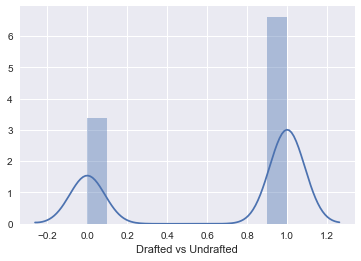

In [33]:
sns.distplot(new_df.Drafted, axlabel = 'Drafted vs Undrafted')

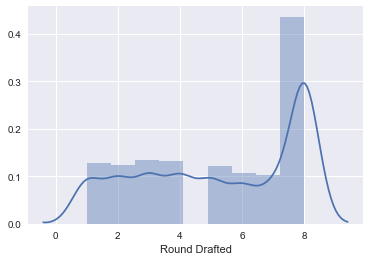

In [34]:
sns.distplot(new_df.Round, axlabel = 'Round Drafted', bins=9)

(array([2141.,    0., 4178.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

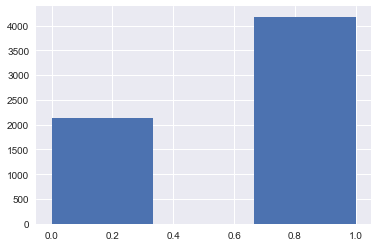

In [35]:
plt.hist(new_df.Drafted, bins=3)

(array([ 628.,  613.,  662.,  654.,  595.,  521.,  505., 2141.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

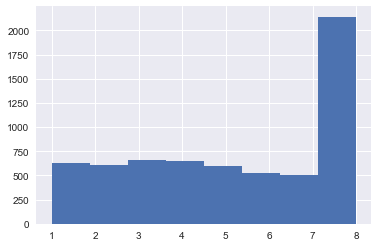

In [36]:
plt.hist(new_df.Round, bins=8)

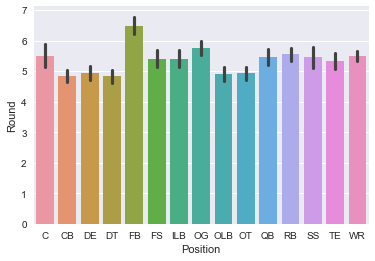

In [37]:
sns.barplot(y=new_df['Round'], x=new_df.Position)

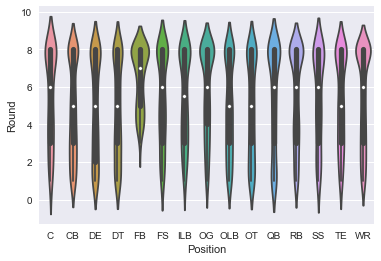

In [38]:
sns.violinplot(y=new_df['Round'], x=new_df.Position, showfliers=False)

In [39]:
# questionable chi-square test
stats.chisquare(new_df.groupby('Position')['Round'].median())

Power_divergenceResult(statistic=0.9289940828402367, pvalue=0.9999993826655221)

### Explore Relationships

In [40]:
new_df.columns

Index(['Year', 'Player', 'Age', 'School', 'Height', 'Wt', '40YD', 'Vertical',
       'BenchReps', 'Broad Jump', '3Cone', 'Shuttle', 'Round', 'Position',
       'Drafted'],
      dtype='object')

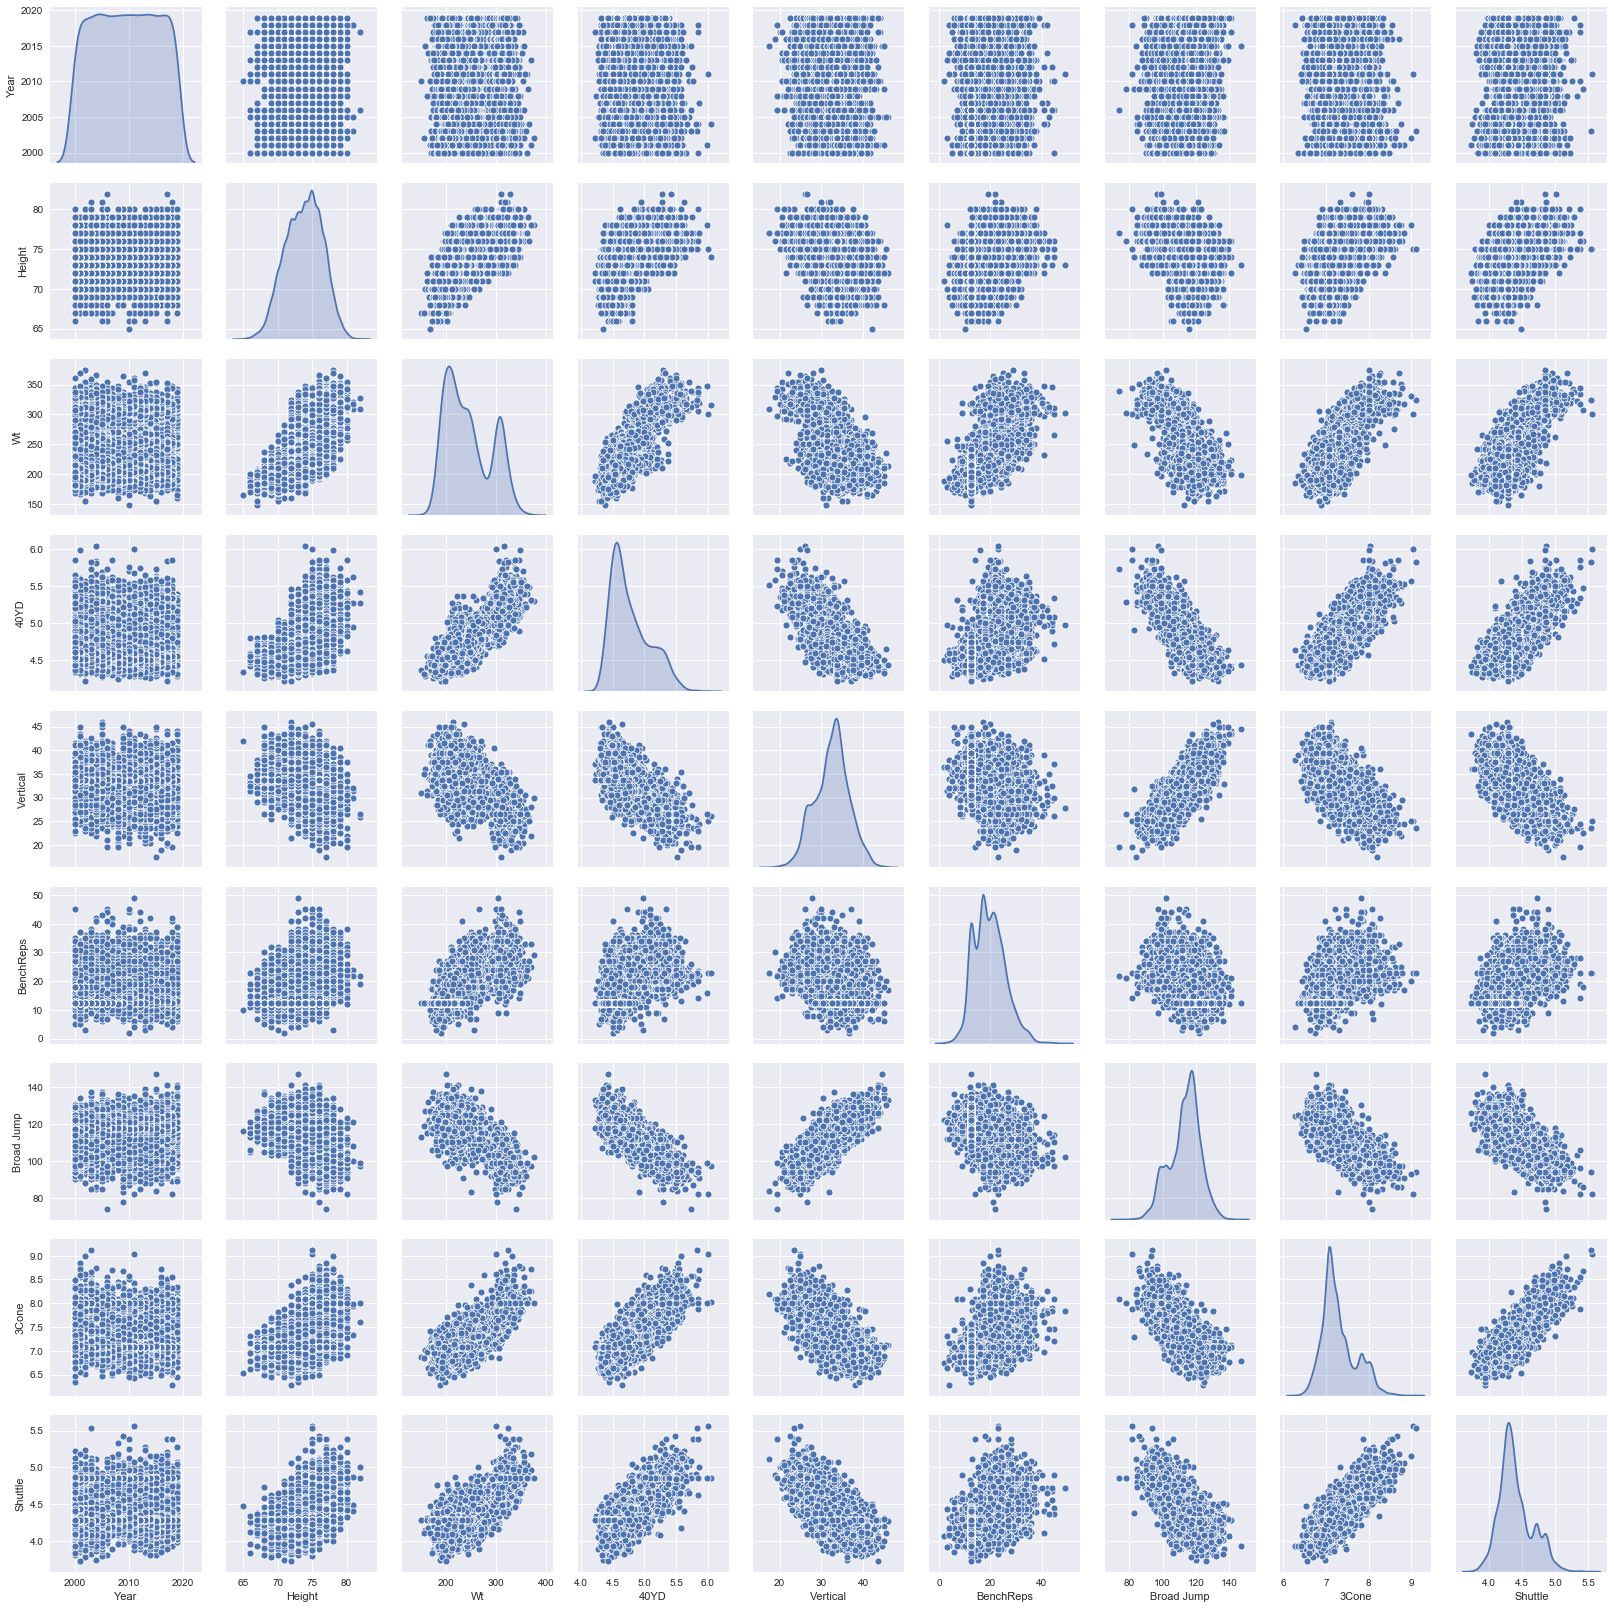

In [41]:
sns.pairplot(new_df.drop(columns = ['Player', 'Age', 'School', 'Round', 'Drafted']) , diag_kind="kde", height=2.5)

### Make Dummies

In [42]:
school_dummies = pd.get_dummies(new_df['School'], drop_first = True)
position_dummies = pd.get_dummies(new_df['Position'], drop_first = True)

In [43]:
new_plus_dummies = pd.concat([new_df, position_dummies],axis = 1).drop(columns = ['Position', 'School'])

In [44]:
new_plus_dummies.shape

(6319, 27)

In [45]:
new_plus_dummies.head()

,Year,Player,Age,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Drafted,CB,DE,DT,FB,FS,ILB,OG,OLB,OT,QB,RB,SS,TE,WR
0,2018,Sean Welsh,23.0,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018,Coleman Shelton,22.0,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018,Frank Ragnow,21.0,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,Scott Quessenberry,22.0,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018,Billy Price,23.0,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position,Drafted
0,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C,0
1,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C,0
2,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C,1
3,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C,1
4,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C,1


### First round of models - Drafted/Undrafted (No Polynomials)

##### Set features and target

In [47]:
X = new_df.drop(columns = ['Round', 'Player', 'Drafted', 'Position', 'School'])
y = new_df['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

#### Random Forest GridSearchCV

In [48]:
param_grid = {'criterion':['gini', 'entropy'],
              'n_estimators':[4500],
              'max_depth':[8,9,10,11],
              'min_samples_split':[5,6],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.776448,0.069193,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.775967,0.069671,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.772028,0.070318,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
3,0.772954,0.069569,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
4,0.767934,0.074771,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
5,0.768730,0.074648,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
6,0.764686,0.077353,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
7,0.763936,0.077647,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
8,0.776947,0.069496,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
9,0.777281,0.068768,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."


In [49]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.7772806926645314
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 4500, 'n_jobs': -1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=4500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#### KNN GridSearchCV

In [50]:
param_grid = {'weights':['uniform', 'distance'],
              'n_neighbors':[5,6,7,8,9],
              'n_jobs':[-1]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
knn_grid.fit(X, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.679252,0.066246,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'u..."
1,0.678236,0.065909,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd..."
2,0.635029,0.076055,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'u..."
3,0.682118,0.070134,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'd..."
4,0.693684,0.070685,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'u..."
5,0.694427,0.069185,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'd..."
6,0.653681,0.079073,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'u..."
7,0.695352,0.067360,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'd..."
8,0.704006,0.067145,"{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'u..."
9,0.701715,0.067478,"{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'd..."


In [51]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.7040055601783319
{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


#### XGBoost GridSearchCV

In [52]:
xg_clf = xgb.XGBClassifier(objective = 'binary:logistic')
param_grid = {'colsample_bytree':[.5],
              'subsample':[.5],
              'learning_rate':[.1,.3],
              'max_depth':[8,9],
              'alpha':[.5,],
              'scale_pos_weight':[.5],
              'n_estimators':[10000],
              'n_jobs':[-1]}
xgb_grid = GridSearchCV(xg_clf, param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
xgb_grid.fit(X, y)
pd.DataFrame(xgb_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.657190,0.102477,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
1,0.658893,0.105810,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
2,0.650736,0.103064,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
3,0.654179,0.103373,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."


In [53]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.6588934364796845
{'alpha': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10000, 'n_jobs': -1, 'scale_pos_weight': 0.5, 'subsample': 0.5}
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


In [55]:
#xgb.plot_importance(xg_clf)
#plt.rcParams['figure.figsize'] = [20,15]
#plt.show()

### Second round of models - Drafted/Undrafted (Polynomials)

##### Create polynomial features

In [56]:
poly_2 = PolynomialFeatures(degree=2, interaction_only=False)
poly_2_df = pd.DataFrame(poly_2.fit_transform(X), columns=poly_2.get_feature_names(X.columns))

#### Random Forest GridSearchCV

In [57]:
param_grid = {'criterion':['gini', 'entropy'],
              'n_estimators':[4500],
              'max_depth':[8,9,10,11],
              'min_samples_split':[5,6],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(poly_2_df, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.778232,0.077183,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.777648,0.076124,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.774693,0.078119,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
3,0.773812,0.077374,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
4,0.770017,0.079577,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
5,0.772435,0.078996,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
6,0.769063,0.079633,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
7,0.769028,0.079091,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
8,0.779163,0.073510,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
9,0.779482,0.074620,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."


In [58]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.7794823342284901
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 4500, 'n_jobs': -1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=4500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#### KNN GridSearchCV

In [59]:
param_grid = {'weights':['uniform', 'distance'],
              'n_neighbors':[5,6,7,8,9],
              'n_jobs':[-1]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
knn_grid.fit(poly_2_df, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.682487,0.064173,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'u..."
1,0.681438,0.064548,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd..."
2,0.634735,0.068863,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'u..."
3,0.683909,0.066151,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'd..."
4,0.693127,0.061222,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'u..."
5,0.693848,0.061337,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'd..."
6,0.661753,0.062973,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'u..."
7,0.692876,0.060099,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'd..."
8,0.706251,0.055098,"{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'u..."
9,0.702051,0.056714,"{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'd..."


In [60]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.7062508017788398
{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


#### XGBoost GridSearchCV

In [61]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic')
param_grid = {'colsample_bytree':[.5],
              'subsample':[.5],
              'learning_rate':[.1,.3],
              'max_depth':[8,9],
              'alpha':[.5],
              'scale_pos_weight':[.5],
              'n_estimators':[10000],
              'n_jobs':[-1]}
xgb_grid = GridSearchCV(xg_clf, param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
xgb_grid.fit(poly_2_df, y)
pd.DataFrame(xgb_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.699049,0.095605,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
1,0.697026,0.103285,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
2,0.691227,0.096775,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
3,0.696261,0.095776,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."


In [62]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.6990488987758674
{'alpha': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 10000, 'n_jobs': -1, 'scale_pos_weight': 0.5, 'subsample': 0.5}
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


### Third round of Models - Round Drafted (No Polynomials)

##### Reset Target

In [63]:
y = new_plus_dummies['Round']

#### Random Forest GridSearchCV

In [64]:
param_grid = {'criterion':['gini', 'entropy'],
              'n_estimators':[4500],
              'max_depth':[8,9,10,11],
              'min_samples_split':[5,6],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.361133,0.013836,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.360817,0.013488,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.356227,0.014268,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
3,0.356069,0.013547,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
4,0.353853,0.016559,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
5,0.353695,0.016058,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
6,0.351005,0.018501,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
7,0.351796,0.019086,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
8,0.361608,0.013432,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
9,0.360658,0.013337,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."


In [65]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.3616078493432505
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 4500, 'n_jobs': -1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=4500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#### KNN GridSearchCV

In [72]:
param_grid = {'weights':['uniform', 'distance'],
              'n_neighbors':[4,5,6,7,8,9],
              'n_jobs':[-1]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
knn_grid.fit(X, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.187688,0.022980,"{'n_jobs': -1, 'n_neighbors': 4, 'weights': 'u..."
1,0.202880,0.023279,"{'n_jobs': -1, 'n_neighbors': 4, 'weights': 'd..."
2,0.197025,0.021135,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'u..."
3,0.212217,0.023582,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd..."
4,0.201931,0.020105,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'u..."
5,0.219180,0.020094,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'd..."
6,0.212692,0.018301,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'u..."
7,0.228517,0.022819,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'd..."
8,0.222345,0.020352,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'u..."
9,0.233107,0.026536,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'd..."


In [73]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.23943661971830985
{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance')


#### XGBoost GridSearchCV

In [74]:
xg_clf = xgb.XGBClassifier(objective ='multi:softmax')
param_grid = {'colsample_bytree':[.5],
              'subsample':[.5],
              'learning_rate':[.1,.3],
              'max_depth':[8,9],
              'alpha':[.5],
              'scale_pos_weight':[.5],
              'n_estimators':[10000],
              'n_jobs':[-1]}
xgb_grid = GridSearchCV(xg_clf, param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
xgb_grid.fit(X, y)
pd.DataFrame(xgb_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.253205,0.031075,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
1,0.255737,0.039379,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
2,0.236588,0.036046,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
3,0.246400,0.037937,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."


In [75]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.2557366671941763
{'alpha': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10000, 'n_jobs': -1, 'scale_pos_weight': 0.5, 'subsample': 0.5}
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


### Fourth round of models - Round Drafted (Polynomials)

#### Random Forest GridSearchCV

In [76]:
param_grid = {'criterion':['gini', 'entropy'],
              'n_estimators':[4500],
              'max_depth':[8,9,10,11],
              'min_samples_split':[5,6],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
rf_grid.fit(poly_2_df, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.360817,0.014596,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.360658,0.015523,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.358285,0.016392,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
3,0.357493,0.016105,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
4,0.354645,0.016966,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
5,0.354328,0.018121,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
6,0.350847,0.017592,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
7,0.351796,0.019244,"{'criterion': 'gini', 'max_depth': 11, 'min_sa..."
8,0.360500,0.012576,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
9,0.360975,0.013649,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."


In [71]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.3612913435670201
{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 4500, 'n_jobs': -1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=4500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#### KNN GridSearchCV

In [79]:
param_grid = {'weights':['uniform', 'distance'],
              'n_neighbors':[4,5,6,7,8,9],
              'n_jobs':[-1]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
knn_grid.fit(poly_2_df, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.186422,0.021041,"{'n_jobs': -1, 'n_neighbors': 4, 'weights': 'u..."
1,0.201931,0.024156,"{'n_jobs': -1, 'n_neighbors': 4, 'weights': 'd..."
2,0.193385,0.021252,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'u..."
3,0.213800,0.023345,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd..."
4,0.197500,0.019424,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'u..."
5,0.220130,0.022984,"{'n_jobs': -1, 'n_neighbors': 6, 'weights': 'd..."
6,0.206045,0.018041,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'u..."
7,0.226935,0.019416,"{'n_jobs': -1, 'n_neighbors': 7, 'weights': 'd..."
8,0.214749,0.016657,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'u..."
9,0.232473,0.018275,"{'n_jobs': -1, 'n_neighbors': 8, 'weights': 'd..."


In [80]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.23706282639658174
{'n_jobs': -1, 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance')


#### XGBoost GridSearchCV

In [81]:
xg_clf = xgb.XGBClassifier(objective ='multi:softmax')
param_grid = {'colsample_bytree':[.5],
              'subsample':[.5],
              'learning_rate':[.1,.3],
              'max_depth':[8,9],
              'alpha':[.5],
              'scale_pos_weight':[.5],
              'n_estimators':[10000],
              'n_jobs':[-1]}
xgb_grid = GridSearchCV(xg_clf, param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
xgb_grid.fit(poly_2_df, y)
pd.DataFrame(xgb_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.275993,0.031301,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
1,0.277259,0.032612,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
2,0.266973,0.029435,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."
3,0.269188,0.033037,"{'alpha': 0.5, 'colsample_bytree': 0.5, 'learn..."


In [82]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.2772590599778446
{'alpha': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10000, 'n_jobs': -1, 'scale_pos_weight': 0.5, 'subsample': 0.5}
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


### Fifth round of models - Random Forest revisited 

In [88]:
y = new_df['Drafted']

param_grid = {'criterion':['entropy'],
              'n_estimators':[10000],
              'max_depth':[3,4,5],
              'min_samples_split':[3,5,7],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.794017,0.005506,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
1,0.794017,0.005506,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
2,0.794094,0.005519,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
3,0.794509,0.019090,"{'criterion': 'entropy', 'max_depth': 4, 'min_..."
4,0.794973,0.018718,"{'criterion': 'entropy', 'max_depth': 4, 'min_..."
5,0.794780,0.019126,"{'criterion': 'entropy', 'max_depth': 4, 'min_..."
6,0.788861,0.040179,"{'criterion': 'entropy', 'max_depth': 5, 'min_..."
7,0.788868,0.041919,"{'criterion': 'entropy', 'max_depth': 5, 'min_..."
8,0.789534,0.040510,"{'criterion': 'entropy', 'max_depth': 5, 'min_..."


In [89]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.7949733380447366
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 10000, 'n_jobs': -1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [97]:
y = new_df['Round']

param_grid = {'criterion':['gini','entropy'],
              'n_estimators':[10000],
              'max_depth':[8,9,10,11],
              'min_samples_split':[3,5,7],
              'class_weight':['balanced', 'balanced_subsample'],
              'n_jobs':[-1]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

KeyboardInterrupt: 

In [ ]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)